# Applying *k*-Means: World Bank Country Data

## Brief

In the Introduction, we used data on fertility rates and female labor force participation rates to find groups of countries. We applied k-means to find potential clusters of countries. 

Today, we're going to continue with this example and move beyond two dimensions by including two other features in our dataset. The data is from the 2018 World Bank Development Indicators, which you can look at by clicking [this link](https://databank.worldbank.org/source/world-development-indicators#).

Take a look at the data dictionary below:

|Variable|Full variable name|Description|
|:---|:---|:---|
|country|Country name|The full name of the country.|
|female_labor|Female labor force participation rate|The percentage of females ages 15 and older that are economically active, i.e., part of the labor force.|
|fertility_rate|Fertility rate|The average number of births for a woman who lives to the end of her childbearing years.|
|gdp_pc|GDP per capita|Gross domestic product of a country in USD.|
|unemployment_rate|Unemployment rate|The percentage of the labor force that is unemployed.|

### *The goal of this notebook is to:*
- Cluster on multi-dimensional data using k-means
- Review the inertia score and learn about the silhouette score
- Discuss some strengths and weaknesses of k-means - in particular, its sensitivity to outliers and initial centroid placement

## Import libraries

We'll mostly be working with `scikit-learn` for our analysis again. You can refer to the documentation on its clustering functions at [this link](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.cluster): On sklearn clustering functions).

### *Task 1 - import libraries*
Load in the relevant packages into the notebook. We'll mostly be working with `scikit-learn` for our analysis again.

In [1]:
# for loading and manipulating dataframes
import pandas as pd
import numpy as np

# for various plotting functions
import matplotlib.pyplot as plt
import seaborn as sns

# preprocessing functions to pre-process our data
from sklearn.preprocessing import scale, StandardScaler, normalize
from scipy import stats

# functions to carry out our k-means clustering algorithm
from sklearn.cluster import KMeans

# functions for evaluation metrics
from sklearn.metrics import silhouette_score

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

## Load and explore the data
### *Task 2 - load data*
Load `countries.csv` into a variable named `data`.

In [2]:
# load the data
data = pd.read_csv("countries.csv")

### *Task 3 - explore the data*
- Gain an overview of the data using `.info()`. Are the data types what you'd expect? Are there any missing values? 
- Look at the summary statistics of the data using `describe()`. Does it look like there are any outliers? Do the variables have different scales? 

In [3]:
# gain overview of data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 179 entries, 0 to 178
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   country            179 non-null    object 
 1   female_labor       179 non-null    float64
 2   fertility_rate     179 non-null    float64
 3   gdp_pc             179 non-null    float64
 4   unemployment_rate  179 non-null    float64
dtypes: float64(4), object(1)
memory usage: 7.1+ KB


In [4]:
# get summary stats
data.describe()

,female_labor,fertility_rate,gdp_pc,unemployment_rate
count,179.00000,179.000000,179.000000,179.000000
mean,41.37257,2.683631,14273.625754,7.107207
std,9.30866,1.298382,19431.092663,5.417298
min,7.90000,0.980000,281.970000,0.110000
25%,39.11000,1.675000,2000.720000,3.525000
50%,44.23000,2.240000,5639.900000,5.370000
75%,47.65000,3.600000,16647.960000,9.155000
max,55.96000,6.910000,104261.940000,26.910000


---

# Perform Cluster Analysis

Now that we've loaded and explored the data, it's time to perform a cluster analysis. As a reminder, our steps to do so are: 
1. Determine if clustering is appropriate for the task 
2. Pre-process the data
3. Carry out the algorithm 
4. Evaluate the results
5. Interpret the results

## 1. Determining if clustering is appropriate
We know from our brief and previous challenge in the introduction that clustering is suitable for our task of clustering countries.

## 2. Pre-process the data
Pre-processing steps often involve feature selection and feature transformation.
- **Feature selection:**  We'll include all four variables in this analysis.
- **Feature transformation:** We'll scale our data so that each variable contributes equally to the clustering.

### *Task 4 - scale the data* 
Scale the data using `StandardScaler()` from `sklearn` and store the scaled data in a variable named `data_scaled`. For a refresher, you can refer to [the documentation](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html).

In [5]:
# create scaling object
scaler = StandardScaler()

# scale our variables 
data_scaled = scaler.fit_transform(data.drop('country', axis=1))

## 3. Carry out the algorithm & 4. Evaluate the Results

In the introduction, we first applied the k-means algorithm and then evaluated the results to select *k* number of clusters. In practice, we typically evaluate results simultaneously to help with hyperparameter selection. 

In this analysis, we'll look at inertia and silhouette scores to select the number of clusters *k* before running the final algorithm on our data.

### *Task 5 - elbow method* 
- Plot the inertia scores for a range of *k* values in an elbow plot.
- Briefly comment on the number of clusters you would choose based on the elbow plot.

In [6]:
# use the elbow method with inertia to find the optimal value of k

# initialize list of ks and list to store inertia scores
inertias = []
Ks = range(1, 15)

# iterate over the values for k
for i in Ks:
    
    # initialize a kmeans mod with k clusters
    kmeans = KMeans(n_clusters=i) 
    
    # fit the data to the scaled data
    kmeans.fit_predict(data_scaled)
    
    # add the inertia score to the list of scores
    inertias.append(kmeans.inertia_)

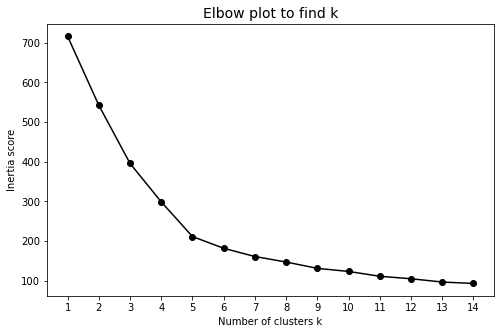

In [7]:
# plot the inertias in an elbow plot
plt.figure(figsize=(8, 5))

plt.plot(Ks, inertias, 'o-', label="inertias", color='black')
plt.xticks(Ks)
plt.title("Elbow plot to find k", fontsize=14)
plt.xlabel("Number of clusters k", fontsize=10)
plt.ylabel("Inertia score", fontsize=10)

plt.show()

We can see that the elbow of the plot is located around *k*=5, which indicates that five clusters would be a good choice.

### *Task 6 - silhouette score*
The **silhouette score** is another metric that we can use to evaluate our clustering and help select our parameter *k*. The silhouette score is a measure of both cluster cohesion (how compact the clusters are) and cluster separation (how well-separated each cluster is from one another).
  
The details of how the silhouette score is calculated will be covered in the online practice, but for now it's important for us to know that the metric takes on a value between -1 and 1, with a higher score indicating a better clustering.

Similar to inertia, we select *k* by calculating the silhouette score at a range of values for *k*. Rather than an elbow plot, we can plot the silhouette scores against values of *k* using a bar or line plot, and then select the *k* number of clusters with the best score.

Using the function `silhouette_score()` from `sklearn`:
- Plot the silhouette score for a range of *k* values in a bar plot.
- Comment on the number of clusters you would choose based on the silhouette score plot.

In [8]:
# initialize list of ks and list to store silhouette scores
scores = [] 
Ks = range(2,15)

for i in Ks:
    # initialize a kmeans model with k clusters
    kmeans_mod = KMeans(n_clusters=i, random_state=123)
    
    # fir the model to the scaled data
    preds = kmeans_mod.fit_predict(data_scaled)
    
    # get the silhouette score for the cluster
    score = silhouette_score(data_scaled, preds)
    
    # add it to the list of silhouette scores
    scores.append(score) 

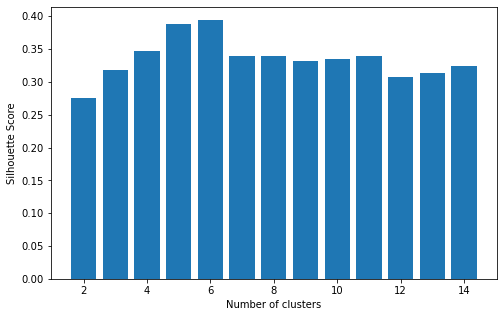

In [9]:
# plot a bar graph to compare the results 
plt.figure(figsize=(8, 5))

plt.bar(Ks, scores) 
plt.xlabel('Number of clusters', fontsize = 10) 
plt.ylabel('Silhouette Score', fontsize = 10) 
plt.show()

The highest silhouette score is when *k*=6, so this would be our selection for the number of clusters *k* from the bar plot. This gives us a more clear selection for *k* than finding the elbow using inertia. For this analysis, we'll choose to find 6 clusters.

### *Task 7 - apply k-means*
- Apply k-means to the scaled data with your selection for *k* number of clusters. Use the `KMeans()` function from `sklearn`. You can refer to the documentation at [this link](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html).

- Add the cluster labels in a new column named 'cluster' in the dataframe `data`.

In [10]:
# create k-means class object 
# and select hyperparameters
kmeans_mod  = KMeans(n_clusters=6, random_state=123)

# fit the model to the (scaled) data
kmeans_mod.fit(data_scaled)

KMeans(n_clusters=6, random_state=123)

In [11]:
# add cluster labels to new column in original data frame
data['cluster'] = kmeans_mod.labels_

### *Task 8 - inspect cluster centroids*
- Inspect the resulting cluster centroids using the `.cluster_centers_` attribute from the `KMeans()` model after it's fit to the data. The centroid arrays are in order of the original columns of the dataframe. 

In [12]:
# inspect the resulting cluster centroids
print(kmeans_mod.cluster_centers_)

[[ 0.51727627  1.47006621 -0.65669235 -0.50044137]
 [ 0.1841816  -0.50283875 -0.25517656 -0.36376477]
 [ 0.51933209 -0.83694227  1.8643421  -0.31460468]
 [ 0.26311856 -0.39529868 -0.36946129  1.91835805]
 [-2.06285719  0.80162727 -0.59023688  1.27365814]
 [-2.2218115  -0.3535801   0.16330044 -0.56268517]]


In [13]:
# we can store these values in a dataframe to look at them more easily.
cluster_centroids_df = pd.DataFrame(kmeans_mod.cluster_centers_)

# add column names 
cluster_centroids_df.columns = data.columns[1:-1]

# view the centroid for each cluster
cluster_centroids_df

,female_labor,fertility_rate,gdp_pc,unemployment_rate
0,0.517276,1.470066,-0.656692,-0.500441
1,0.184182,-0.502839,-0.255177,-0.363765
2,0.519332,-0.836942,1.864342,-0.314605
3,0.263119,-0.395299,-0.369461,1.918358
4,-2.062857,0.801627,-0.590237,1.273658
5,-2.221812,-0.353580,0.163300,-0.562685


---

<h1><center>Group Work</center></h1>

# 5. Interpret the Results
### *Task 9 - cluster membership*
- Display the number of countries in each cluster. *Hint:* `value_counts()` from the `pandas` library helps to show the number of unique values in a column.
- Display the names of the countries within each of the clusters.

In [14]:
# print the number of countries in each cluster
data['cluster'].value_counts()

1    62
0    40
2    30
3    22
4    13
5    12
Name: cluster, dtype: int64

In [15]:
# print the names of the countries within each cluster
for i in range(data['cluster'].nunique()):    
    print("---------------------------------")
    print("Cluster ", i)
    print("| ".join(data.loc[data['cluster'] == i, 'country']))

---------------------------------
Cluster  0
Angola| Benin| Burkina Faso| Burundi| Cameroon| Central African Republic| Chad| Comoros| Congo, Dem. Rep.| Congo, Rep.| Cote d'Ivoire| Equatorial Guinea| Ethiopia| Gambia, The| Ghana| Guinea| Guinea-Bissau| Kenya| Liberia| Madagascar| Malawi| Mali| Mozambique| Niger| Nigeria| Papua New Guinea| Rwanda| Samoa| Senegal| Sierra Leone| Solomon Islands| Tajikistan| Tanzania| Timor-Leste| Togo| Tonga| Uganda| Vanuatu| Zambia| Zimbabwe
---------------------------------
Cluster  1
Argentina| Azerbaijan| Barbados| Belarus| Belize| Bhutan| Bolivia| Brunei Darussalam| Bulgaria| Cambodia| Chile| China| Colombia| Costa Rica| Croatia| Cuba| Czech Republic| Djibouti| Dominican Republic| Ecuador| El Salvador| Estonia| Fiji| Guatemala| Honduras| Hungary| Indonesia| Jamaica| Kazakhstan| Kyrgyz Republic| Lao PDR| Latvia| Lithuania| Malaysia| Malta| Mauritius| Mexico| Moldova| Mongolia| Myanmar| Nepal| Nicaragua| Panama| Paraguay| Peru| Philippines| Poland| Port

### *Task 10 - pair plot*
Because the dataset is multi-dimensional, we can no longer plot all the data at once on a single scatter plot. Instead, one option to visualize the clusters is to create a pair plot which creates a scatter plot between each variable combination. If we color the pair plot based on cluster membership, we can gain a sense of how each cluster differs from one another for each feature.

Using `pairplot()` from the `seaborn` library:
- Create a pair plot of the data, with the values colored by cluster membership.
- Write a few sentences commenting on the differences between each cluster. 
- *Hint:* One approach is to review the results going cluster by cluster, and take note of their distribution of values are for each variable (e.g. *'Cluster 0: high fertility rate, low GDP per capita, etc. | Cluster 1: high fertility rate, etc.'* and so on.)  

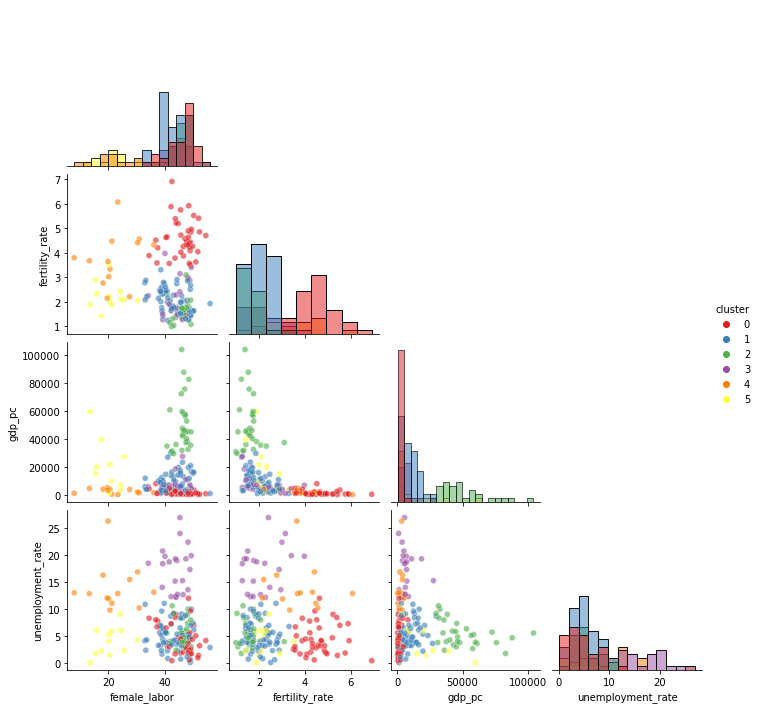

In [16]:
# graph a pair plot with points colored by cluster membership 
sns.pairplot(data,
             corner=True,
             hue='cluster',
             diag_kind='hist', 
             palette='Set1',
             plot_kws={'alpha':0.6})

---

# The limitations of k-means (select one challenge)
## Challenge 1 - Outliers
In our prior pre-processing of the data, we scaled our data. However, we should also consider if and how we want to handle outlier values. 

### *Task 1 - run k-means excluding outlier values* 
- Perform the same cluster analysis as above, with the addition of removing any observations with outlier values in the data before scaling the data. 
    * Skip *Step 4: Evaluation* (with the inertia and silhouette score plots). For ease of comparison to the previous analysis, choose the same number of clusters as before, *k*=6.
    * *Hint*: You can use `zscore()` from the `stats` packages to get the z-score for each value. Z-scores past the standard threshold of `z < -3` or `z > 3` can be considered outliers and the observation can be dropped.

In [17]:
# Step 2 - preprocessing: Remove outliers

# get non-outlier rows where z-scores is less than abs(3)
data_no_outliers = data[(abs(stats.zscore(data.drop(columns=['country', 'cluster']))) < 3).all(axis=1)]

# remove cluster columns (since appended earlier)
data_no_outliers = data_no_outliers.drop(columns='cluster')

In [18]:
# Step 2 - preprocessing: scale the data

# create scaling object
scaler = StandardScaler()

# scale our variables 
data_no_outliers_scaled = scaler.fit_transform(data_no_outliers.drop('country', axis=1))

In [19]:
# Step 3 - carry out algorithm

# instantiate the k-means model with k=6 
kmeans_mod  = KMeans(n_clusters=6, random_state=123)

# fit the model to the (scaled) data
kmeans_mod.fit(data_no_outliers_scaled)

KMeans(n_clusters=6, random_state=123)

In [20]:
# add cluster labels to data 
data_no_outliers['cluster'] = kmeans_mod.labels_

In [21]:
# Step 5 - explore and interpret the results
# inspect cluster centers
cluster_centroids_df = pd.DataFrame(kmeans_mod.cluster_centers_)

# add column names 
cluster_centroids_df.columns = data_no_outliers.columns[1:-1]

# view the centroid for each cluster
cluster_centroids_df

,female_labor,fertility_rate,gdp_pc,unemployment_rate
0,0.467400,-0.832520,1.921837,-0.238142
1,0.563457,1.470719,-0.714099,-0.496300
2,0.170677,-0.501893,-0.256288,-0.395843
3,-1.825062,0.658046,-0.587557,0.972492
4,0.208720,-0.419702,-0.341965,1.961477
5,-2.548154,-0.466278,0.641583,-0.684658


In [22]:
# print the number of countries in each cluster
data_no_outliers['cluster'].value_counts()

2    59
1    38
0    27
4    21
3    14
5     9
Name: cluster, dtype: int64

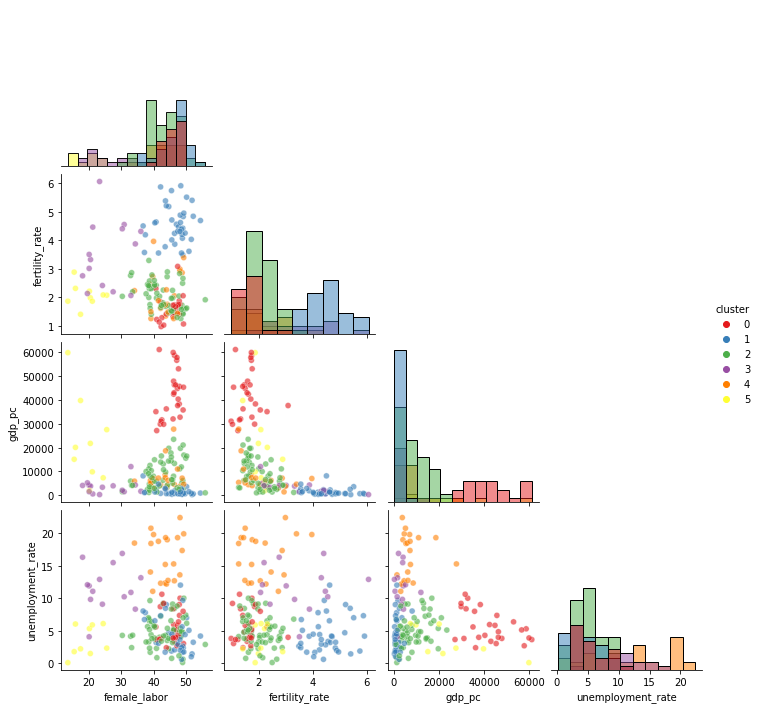

In [23]:
# pair plot with points colored by cluster membership 
sns.pairplot(data_no_outliers,
             corner=True,
             hue='cluster',
             diag_kind='hist', 
             palette='Set1',
             plot_kws={'alpha':0.6})

### *Task 2 - k-means and outliers* 
Briefly answer the following questions: 
- How do the results differ from the analysis where we kept all the observations? You can answer one or more of the following questions to help you answer this question.
    * How do the cluster sizes differ when there are no outliers? 
    * Do the cluster centers differ when there are no outliers? 
    * How does the pair plot (with observations colored by cluster membership) differ? 
- What are potential advantages and disadvantages of removing outliers when using k-means?
- How is the sensitivity of k-means to outliers a disadvantage of the algorithm?

*Your answer here:*

We can see that the results slightly differ when we remove the outliers from our analysis. The centroid values are imapcted, and so are the cluster sizes (naturally fewer observations) and their distribution (some clusters have fewer than 10 countries now). 

A potential advantage of the removing outliers when using k-means is that the the values don't disproportionately impact the centers. Because the cluster centers are calculated using the mean values, any values which are farther away from the center have a greater influence on its value, and the centers might not be representative of the rest of the values in the cluster. 

A potential disadvantage is if the outlier values are important to your analysis. For example, in this analysis, we might want to have a cluster assignment for every country, rather than excluding those with outlier values. 

We can see that because k-means is influenced by the presence of outliers, this is one limitation of the algorithm.  This is discussed in more detail in the online practice. Other algorithms, such as DBSCAN, are able to detect and handle outliers without them influencing the results.

---

## Challenge 2 - Centroid initialization 

The `init` parameter sets how the model finds the initial centroids. By default, `sklearn` sets `init='kmeans++'`, which is a special algorithm that chooses the initial centroids more optimally than at random. When the argument is set to `'random'`, the initial centroids are assigned randomly. 

In our cluster analysis above, the `init` parameter was set to `k-means++` by default. However, we should consider what effect this has on our results.

### *Task 1 - run k-means with random initialization*
- Perform the same cluster analysis as above (with all observations), but with the additional hyperparameter in the `KMeans()` model `init='random'` to set the initial centroids randomly.
- Skip *Step 4: Evaluation* (with the inertia and silhouette score plots). For ease of comparison to the previous analysis, choose the same number of clusters as before, *k*=6.

In [24]:
# Step 3 - carry out algorithm

# apply k-means with k=6
kmeans_mod = KMeans(n_clusters=6, init='random')

# fit the model to the (scaled) data
kmeans_mod.fit(data_scaled)

# add cluster labels to new column in original data frame
# add in country names 
data['cluster_random'] = kmeans_mod.labels_

In [25]:
# Step 5 - explore and interpret the results
# inspect cluster centers
cluster_centroids_df = pd.DataFrame(kmeans_mod.cluster_centers_)

# add column names 
cluster_centroids_df.columns = data_no_outliers.columns[1:-1]

# view the centroid for each cluster
cluster_centroids_df

,female_labor,fertility_rate,gdp_pc,unemployment_rate
0,0.519332,-0.836942,1.864342,-0.314605
1,-2.032030,-0.288022,0.071964,-0.583378
2,0.226792,-0.532584,-0.242230,-0.370679
3,-2.062857,0.801627,-0.590237,1.273658
4,0.517276,1.470066,-0.656692,-0.500441
5,0.244079,-0.376555,-0.378495,1.866765


In [26]:
# print the number of countries in each cluster
data_no_outliers['cluster'].value_counts()

2    59
1    38
0    27
4    21
3    14
5     9
Name: cluster, dtype: int64

### *Task 2 - k-means and centroid initialization*
Briefly answer the following questions: 
- How do the results differ from the analysis where the default initialization was set to `init='kmeans++'`? You can answer one or more of the following questions to help you answer this question.
    * How do the cluster sizes differ? 
    * How do the final centroid values differ??
    * What happens if you were to run the algorithm again with `init='random'?` Are the results the same? 
- What are potential advantages and disadvantages of placing the initial centroids randomly when applying k-means?
- How is the sensitivity of k-means to centroid initialization a limitation of the algorithm?

*Your answer here:*

We can see that the results slightly differ when we have random initialization in our analysis. The centroid values are impacted, and the distribution of cluster memebership is also affected.

A potential advantage of randomly initializing the cluster centers is it's easier and simpler to implement. However, `KMeans()` automatically uses the k-means++ technique for initialization, so for the data analyst, random initialization isn't as beneficial.

A potential disadvantage of random initialization is that, at times, we might get suboptimal results. There are better natural partitionings of the data, which are more difficult to be found when the initialization is random. 

We can see that because k-means is sensitive to centroid initialization, this is one limitation of the algorithm. This is discussed in more detail in the online practice.

---

# Next steps
In the online practice, you'll perform a customer segmentation analysis using clustering. We'll discuss the silhouette score and some additional weaknesses of k-means in-depth. 

You'll also have the chance to explore alternative algorithms to k-means, and we'll learn how we can apply PCA as an additional step in our cluster analysis for dimensionality reduction.

---

# *Optional stretch*: Using `Yellowbricks` for evaluation
The `yellowbrick` package offers several in-built visualization functions to help us examine evaluation metrics such as inertia and the silhouette score. Take a look at the [package documentation](https://www.scikit-yb.org/en/latest/api/cluster/index.html).

### *Task 1 - import  visualizers*
Import the `KElbowVisualizer` and `SilhouetteVisualizer` from the package by running the code cell below. 

In [27]:
# import visualizers from the library
from yellowbrick.cluster import KElbowVisualizer
from yellowbrick.cluster import SilhouetteVisualizer

### *Task 2 - elbow visualizer with inertia*

The function `KElbowVisualizer` fits the `KMeans()` model from `sklearn` to your data and gives a visualizer for the elbow method. By default the plot shows the inertia score, or what the package refers to as the `'distortion'` score.

Take a look at the documentation for the visualizer at [this link](https://www.scikit-yb.org/en/latest/api/cluster/elbow.html).

- Implement the elbow method visualizer on any k-means model above, or a new model of your choosing.
- Comment briefly on the output. If you used a model that you used above, how does the plot compare? Does the visualizer estimate the elbow to be where you would have guessed it was?

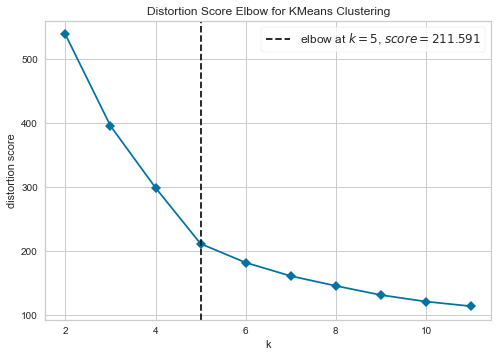

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [28]:
# instantiate the clustering model and visualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2, 12), timings=False)

# fit the data to the visualizer
visualizer.fit(data_scaled) 

# finalize and render the figure
visualizer.show()        

### *Task 3 - silhouette score plot* 
The same visualization `KElbowVisualizer` can be used to create a line plot of silhouette scores for different values of *k*. To do so, we need to set the argument `metric='silhouette'` to calculate and display the silhouette score rather than inertia. 

Additionally, we add in the parameter `locate_elbow=False`. Even though we are plotting the scores on a line plot, it no longer makes sense to try and locate an elbow on the plot, since we are simply looking for the highest silhouette score rather than an elbow.

- Apply the `KElbowVisualizer` on any k-means model above, or a new model of your choosing, looking at the silhouette score metric.
- Comment briefly on the output. If you used a model that you used above, how does the plot compare?

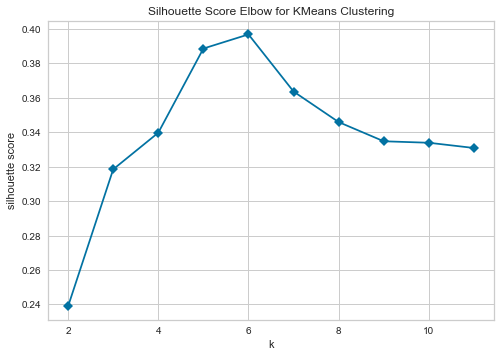

<AxesSubplot:title={'center':'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [29]:
# Instantiate the clustering model and visualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2, 12), metric='silhouette', locate_elbow=False, timings=False)

# Fit the data to the visualizer
visualizer.fit(data_scaled) 

# Finalize and render the figure
visualizer.show()        

### *Task 4 - silhouette score visualizer*
The function `SilhouetteVisualizer` plots the individual silhouette coefficients of a clustering for a given model. The visualizer indicates each cluster by color, and then plots the individual silhouette coefficient values as individual lines. The overall average silhouette score is displayed by default as a red dotted line.

- Apply the `SilhouetteVisualizer` on any k-means model above, or a new model of your choosing with a selected value for *k*.
- Comment briefly on the output. What does this visualizer reveal about our model?

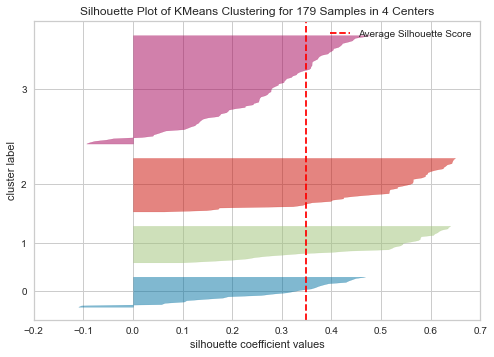

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 179 Samples in 4 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [30]:
# instantiate the clustering model and visualizer
model = KMeans(4, random_state=123)
visualizer = SilhouetteVisualizer(model, colors='yellowbrick')

# fit the data to the visualizer
visualizer.fit(data_scaled) 

# finalize and render the figure
visualizer.show()        